<a href="https://colab.research.google.com/github/UTSAVMON/Gradio-DL/blob/main/DL_Gradio_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gradio

In [2]:
import gradio as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime, os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
batch_size = 32
img_size = (240, 240)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning A1/train/train',
     shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='training', seed=42
)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning A1/test/test',
    shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='validation', seed=42
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning A1/test/test',
    shuffle=True, batch_size=batch_size, image_size=img_size
)

Found 900 files belonging to 3 classes.
Using 720 files for training.
Found 300 files belonging to 3 classes.
Using 60 files for validation.
Found 300 files belonging to 3 classes.


In [6]:
class_names = train_dataset.class_names
print(class_names)

['Dark', 'Light', 'Medium']


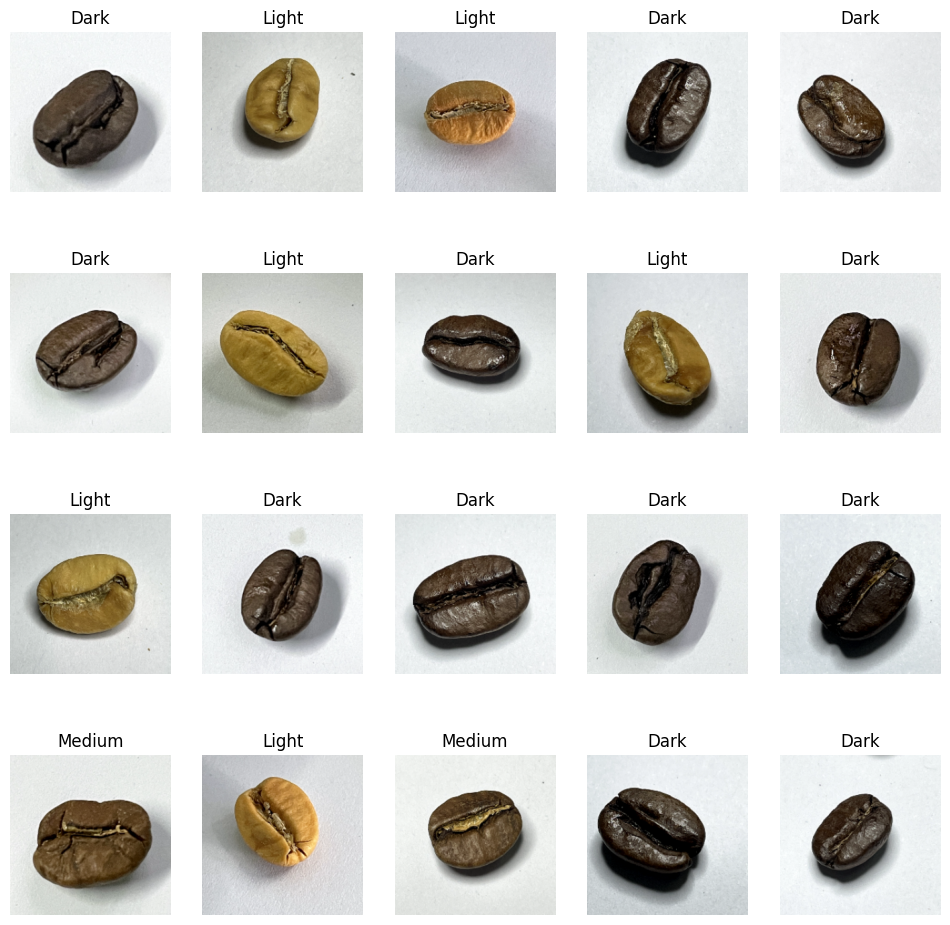

In [7]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis('off')

In [8]:
base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  weights='imagenet',
                                                  include_top=False)

In [9]:

input = keras.layers.Input(shape=(240, 240, 3))

resized_input = keras.layers.Resizing(224, 224)(input)
preprocessed_input = keras.applications.xception.preprocess_input(resized_input)

flip = keras.layers.RandomFlip('horizontal')(preprocessed_input)
rotation = keras.layers.RandomRotation(0.2)(flip)
zoom = keras.layers.RandomZoom(0.2)(rotation)

base_model_output = base_model(zoom)

avg = keras.layers.GlobalAveragePooling2D()(base_model_output)

dropout = keras.layers.Dropout(0.2)(avg)
output = keras.layers.Dense(3, activation='softmax')(dropout)

model = keras.Model(inputs=input, outputs=output)

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

In [12]:
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
23/23 [==============================] - 201s 9s/step - loss: 1.2570 - accuracy: 0.3069 - val_loss: 1.1343 - val_accuracy: 0.3333
Epoch 2/10
23/23 [==============================] - 212s 9s/step - loss: 1.0660 - accuracy: 0.4389 - val_loss: 1.0054 - val_accuracy: 0.4833
Epoch 3/10
23/23 [==============================] - 192s 8s/step - loss: 0.9518 - accuracy: 0.5681 - val_loss: 0.8999 - val_accuracy: 0.6500
Epoch 4/10
23/23 [==============================] - 191s 8s/step - loss: 0.8766 - accuracy: 0.6208 - val_loss: 0.8101 - val_accuracy: 0.7333
Epoch 5/10
23/23 [==============================] - 198s 9s/step - loss: 0.7992 - accuracy: 0.6903 - val_loss: 0.7365 - val_accuracy: 0.7833
Epoch 6/10
23/23 [==============================] - 185s 8s/step - loss: 0.7401 - accuracy: 0.7236 - val_loss: 0.6753 - val_accuracy: 0.8500
Epoch 7/10
23/23 [==============================] - 189s 8s/step - loss: 0.7011 - accuracy: 0.7583 - val_loss: 0.6288 - val_accuracy: 0.8500
Epoch 8/10
23

In [13]:
model.evaluate(test_dataset)

10/10 [==============================] - 87s 7s/step - loss: 0.5203 - accuracy: 0.8800


[0.5203118324279785, 0.8799999952316284]

Predictions:
 [1 1 1 2 2 0 1 1 2 0 0 0 2 1 1 1 0 2 2 0 0 0 1 2 0 1 0 2 2 2 2 0]
Labels:
 [1 1 1 2 2 0 1 1 2 0 2 0 2 1 1 1 0 0 2 0 0 0 1 1 0 1 0 0 1 0 2 0]


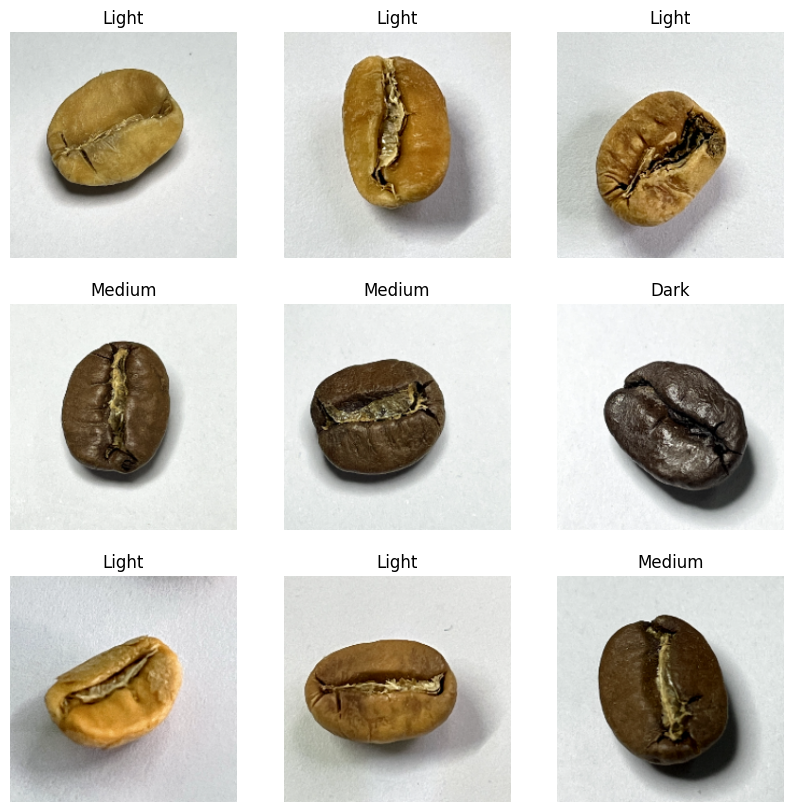

In [14]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions, axis=-1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [15]:
def predict_image(img):
  img_4d=img.reshape(-1,240,240,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [ ]:
image = gr.inputs.Image(shape=(240,240))
label = gr.outputs.Label(num_top_classes=3)
iface = gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default')
iface.launch(debug=True,share=True)

<ipython-input-16-3eb924d923b6>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(240,240))
<ipython-input-16-3eb924d923b6>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(240,240))
<ipython-input-16-3eb924d923b6>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=3)
<ipython-input-16-3eb924d923b6>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=3)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4cabe7df38ff085805.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 1s 1s/step
